# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import warnings

In [4]:
import covsirphy as cs
cs.__version__

'2.9.0'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [5]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Detailed citaition list:
Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/

### The number of cases (JHU style)

In [6]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [7]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

In [8]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
274974,2020-10-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274975,2020-10-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274976,2020-10-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274977,2020-10-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274978,2020-10-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [9]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
274974,2020-10-16,Colombia,Vichada,14,0,0,14
274975,2020-10-17,Colombia,Vichada,14,0,0,14
274976,2020-10-18,Colombia,Vichada,14,0,0,14
274977,2020-10-19,Colombia,Vichada,14,0,0,14
274978,2020-10-20,Colombia,Vichada,14,0,0,14


In [10]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
211,2020-10-16,28601,2079,431,26091
212,2020-10-17,28836,2096,434,26306
213,2020-10-18,28968,2058,436,26474
214,2020-10-19,29046,2033,436,26577
215,2020-10-20,29185,1938,437,26810


In [11]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-10-16,38920089,11175325,1096019,26648745,0.014080,0.342352,0.039504
2020-10-17,39285068,11347299,1101402,26836367,0.014018,0.341559,0.039423
2020-10-18,39584354,11452657,1104652,27027045,0.013953,0.341385,0.039267
2020-10-19,39931173,11610651,1109175,27211347,0.013889,0.340728,0.039165
2020-10-20,39931854,11609689,1109181,27212984,0.013888,0.340743,0.039163


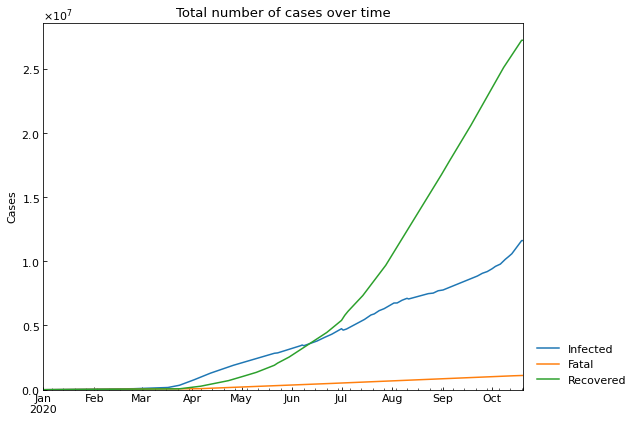

In [12]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [13]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
250,2020-10-16,92053,5960,1664,84429
251,2020-10-17,92677,5995,1670,85012
252,2020-10-18,93108,5968,1674,85466
253,2020-10-19,93425,5848,1676,85901
254,2020-10-20,93908,5756,1679,86473


In [14]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan


In [15]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
248,2020-10-16,91431,5330,1650,84451
249,2020-10-17,92063,5372,1661,85030
250,2020-10-18,92656,5501,1670,85485
251,2020-10-19,93127,5512,1674,85941
252,2020-10-20,93480,5291,1676,86513


### Population in each country

In [16]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [17]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
274974,2020-10-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274975,2020-10-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274976,2020-10-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274977,2020-10-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274978,2020-10-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [18]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
232807,COL,Colombia,Vichada,2020-10-16,107808
232808,COL,Colombia,Vichada,2020-10-17,107808
232809,COL,Colombia,Vichada,2020-10-18,107808
232810,COL,Colombia,Vichada,2020-10-19,107808
232811,COL,Colombia,Vichada,2020-10-20,107808


In [19]:
population_data.value("Japan", province=None)

126529100

In [20]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [21]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [22]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
274974,2020-10-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274975,2020-10-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274976,2020-10-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274977,2020-10-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
274978,2020-10-20,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [23]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
274974,2020-10-16,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
274975,2020-10-17,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
274976,2020-10-18,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
274977,2020-10-19,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
274978,2020-10-20,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3


In [24]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
289,2020-10-16,1,1,1,0,0,1,1,1,2,2,1,31.48
290,2020-10-17,1,1,1,0,0,1,1,1,2,2,1,31.48
291,2020-10-18,1,1,1,0,0,1,1,1,2,2,1,31.48
292,2020-10-19,1,1,1,0,0,1,1,1,2,2,1,31.48
293,2020-10-20,1,1,1,0,0,1,1,1,2,2,1,31.48


In [25]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
289,2020-10-16,1,1,1,0,0,1,1,1,2,2,1,31.48
290,2020-10-17,1,1,1,0,0,1,1,1,2,2,1,31.48
291,2020-10-18,1,1,1,0,0,1,1,1,2,2,1,31.48
292,2020-10-19,1,1,1,0,0,1,1,1,2,2,1,31.48
293,2020-10-20,1,1,1,0,0,1,1,1,2,2,1,31.48


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [26]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

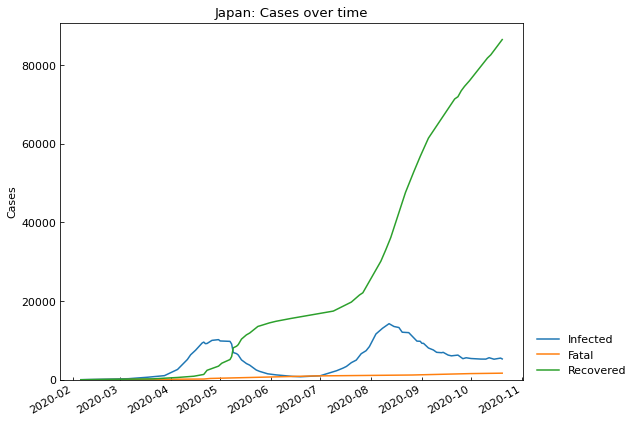

,Date,Confirmed,Infected,Fatal,Recovered
248,2020-10-16,91431,5330,1650,84451
249,2020-10-17,92063,5372,1661,85030
250,2020-10-18,92656,5501,1670,85485
251,2020-10-19,93127,5512,1674,85941
252,2020-10-20,93480,5291,1676,86513


In [27]:
# import matplotlib
# warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = snl.records()
record_df.tail()

### S-R trend analysis

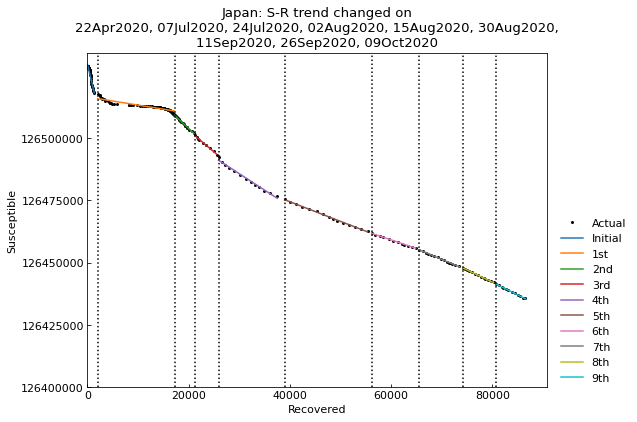

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,06Jul2020,126529100
2nd,Past,07Jul2020,23Jul2020,126529100
3rd,Past,24Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,29Aug2020,126529100
6th,Past,30Aug2020,10Sep2020,126529100
7th,Past,11Sep2020,25Sep2020,126529100
8th,Past,26Sep2020,08Oct2020,126529100
9th,Past,09Oct2020,20Oct2020,126529100


In [28]:
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [29]:
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 9th phase (09Oct2020 - 20Oct2020): finished  722 trials in 0 min 25 sec


	 2nd phase (07Jul2020 - 23Jul2020): finished  175 trials in 0 min  5 sec

	 3rd phase (24Jul2020 - 01Aug2020): finished 1065 trials in 0 min 40 sec

	 5th phase (15Aug2020 - 29Aug2020): finished  478 trials in 0 min 15 sec

	 0th phase (06Feb2020 - 21Apr2020): finished 1426 trials in 1 min  0 sec

	 1st phase (22Apr2020 - 06Jul2020): finished 1436 trials in 1 min  0 sec

	 6th phase (30Aug2020 - 10Sep2020): finished  320 trials in 0 min 10 sec

	 4th phase (02Aug2020 - 14Aug2020): finished 1487 trials in 1 min  0 sec

	 7th phase (11Sep2020 - 25Sep2020): finished  556 trials in 0 min 15 sec

	 8th phase (26Sep2020 - 08Oct2020): finished 1818 trials in 1 min  0 sec

Completed optimization. Total: 2 min 26 sec


In [30]:
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/alpha2 [day],alpha1 [-],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.66,0.018341,0.000174,0.104200,0.021769,1440,5760,0.018,45,9,0.937856,1426,1 min 0 sec
1st,Past,22Apr2020,06Jul2020,126529100,SIR-F,0.37,0.111664,0.000268,0.027925,0.065885,1440,3732,0.112,15,35,0.916719,1436,1 min 0 sec
2nd,Past,07Jul2020,23Jul2020,126529100,SIR-F,1.93,0.000466,0.000080,0.133382,0.068954,1440,12426,0.000,14,7,0.031898,175,0 min 5 sec
3rd,Past,24Jul2020,01Aug2020,126529100,SIR-F,1.84,0.000726,0.000120,0.134241,0.072807,1440,8341,0.001,13,7,0.019265,1065,0 min 40 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.57,0.001253,0.000304,0.102607,0.065073,1440,3284,0.001,15,9,0.062261,1487,1 min 0 sec
5th,Past,15Aug2020,29Aug2020,126529100,SIR-F,0.79,0.000844,0.000831,0.073977,0.093038,1440,1204,0.001,10,13,0.024730,478,0 min 15 sec
6th,Past,30Aug2020,10Sep2020,126529100,SIR-F,0.67,0.000277,0.001423,0.063356,0.092474,1440,702,0.000,10,15,0.012941,320,0 min 10 sec
7th,Past,11Sep2020,25Sep2020,126529100,SIR-F,0.85,0.016642,0.000046,0.085008,0.097873,1440,21764,0.017,10,11,0.031336,556,0 min 15 sec
8th,Past,26Sep2020,08Oct2020,126529100,SIR-F,1.01,0.000972,0.001053,0.093356,0.091061,1440,949,0.001,10,10,0.017946,1818,1 min 0 sec
9th,Past,09Oct2020,20Oct2020,126529100,SIR-F,1.04,0.001755,0.000598,0.104236,0.099343,1440,1672,0.002,10,9,0.018525,722,0 min 25 sec


### Accuracy of estimation

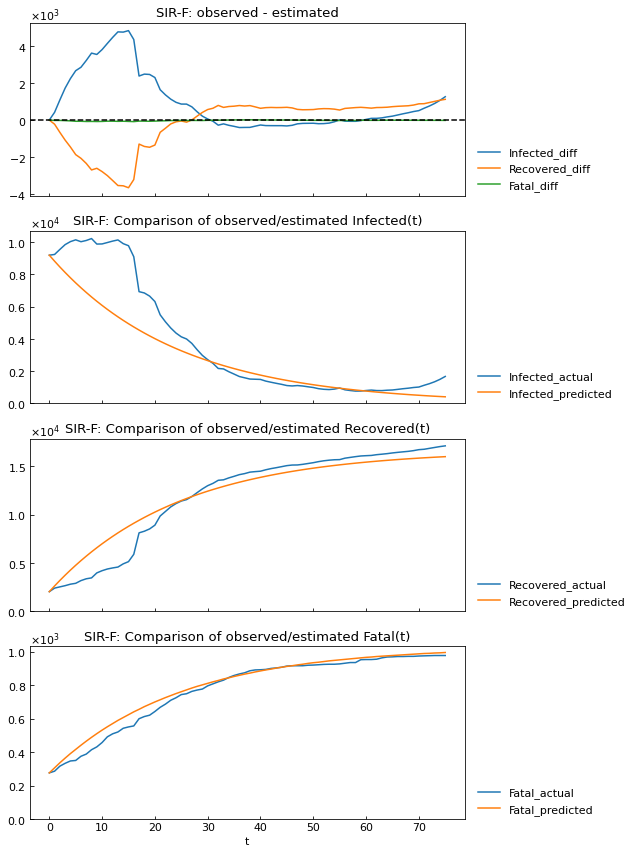

In [31]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [32]:
snl.get("Rt", phase="4th")

1.57

### Show parameter history

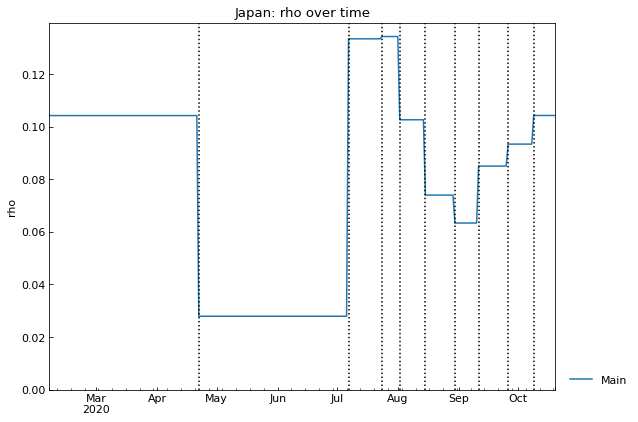

In [33]:
_ = snl.history(target="rho")

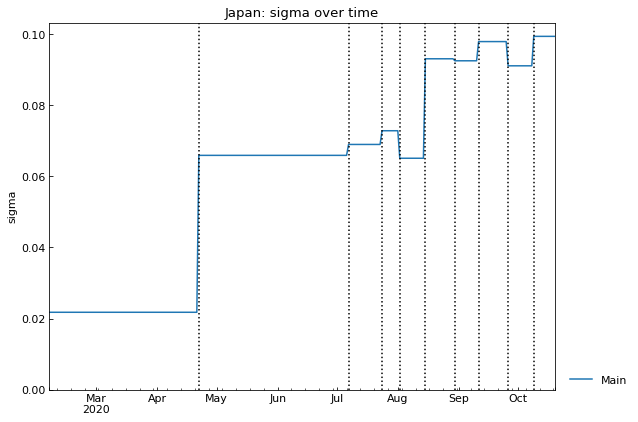

In [34]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

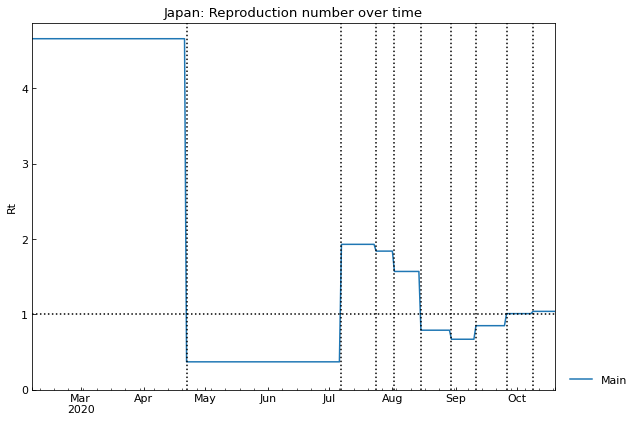

In [35]:
_ = snl.history(target="Rt")

### Simulate the number of cases

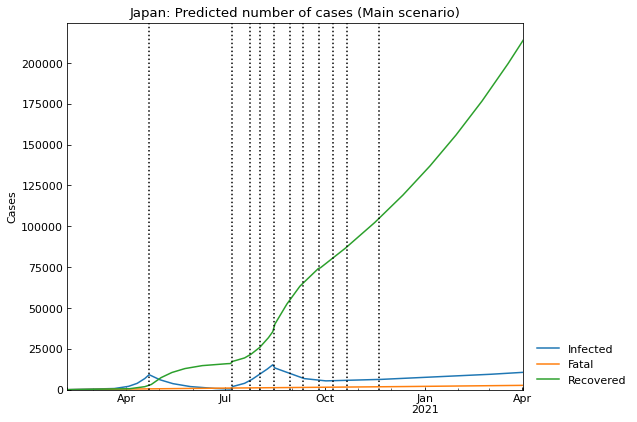

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,222920,2630,10468,209822
418,2021-03-30,224012,2639,10509,210864
419,2021-03-31,225108,2647,10551,211910
420,2021-04-01,226207,2655,10592,212960
421,2021-04-02,227312,2663,10634,214015


In [36]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [37]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.09934311455910727

In [38]:
sigma_new = sigma_current * 2
sigma_new

0.19868622911821454

In [39]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.66   
         1st      Past  22Apr2020  06Jul2020   126529100  SIR-F  0.37   
         2nd      Past  07Jul2020  23Jul2020   126529100  SIR-F  1.93   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.84   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.57   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.79   
         6th      Past  30Aug2020  10Sep2020   126529100  SIR-F  0.67   
         7th      Past  11Sep2020  25Sep2020   126529100  SIR-F  0.85   
         8th      Past  26Sep2020  08Oct2020   126529100  SIR-F  1.01   
         9th      Past  09Oct2020  20Oct2020   126529100  SIR-F  1.04   
         10th   Future  21Oct2020  19Nov2020   126529100  SIR-F  1.04   
         11th   Future  20Nov2020  01Apr2021   126529100  SIR-F  1.04   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.66   
         1st      Past  22Apr2020  06Jul2020   126529100  SIR-F  0.37   
         2nd      Past  07Jul2020  23Jul2020   126529100  SIR-F  1.93   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.84   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.57   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.79   
         6th      Past  30Aug2020  10Sep2020   126529100  SIR-F  0.67   
         7th      Past  11Sep2020  25Sep2020   126529100  SIR-F  0.85   
         8th      Past  26Sep2020  08Oct2020   126529100  SIR-F  1.01   
         9th      Past  09Oct2020  20Oct2020   126529100  SIR-F  1.04   
         10th   Future  21Oct2020  19Nov2020   126529100  SIR-F  1.04   
         11th   Future  20Nov2020  01Apr2021   126529100  SIR-F  0.52   

                   theta     kappa       rho     sigma   tau  1/alpha2 [day]  \
Scenario Phase                                                                 
Main     0th    0.018341  0.000174  0.104200  0.021769  1440            5760   
         1st    0.111664  0.000268  0.027925  0.065885  1440            3732   
         2nd    0.000466  0.000080  0.133382  0.068954  1440           12426   
         3rd    0.000726  0.000120  0.134241  0.072807  1440            8341   
         4th    0.001253  0.000304  0.102607  0.065073  1440            3284   
         5th    0.000844  0.000831  0.073977  0.093038  1440            1204   
         6th    0.000277  0.001423  0.063356  0.092474  1440             702   
         7th    0.016642  0.000046  0.085008  0.097873  1440           21764   
         8th    0.000972  0.001053  0.093356  0.091061  1440             949   
         9th    0.001755  0.000598  0.104236  0.099343  1440            1672   
         10th   0.001755  0.000598  0.104236  0.099343  1440            1672   
         11th   0.001755  0.000598  0.104236  0.099343  1440            1672   
Medicine 0th    0.018341  0.000174  0.104200  0.021769  1440            5760   
         1st    0.111664  0.000268  0.027925  0.065885  1440            3732   
         2nd    0.000466  0.000080  0.133382  0.068954  1440           12426   
         3rd    0.000726  0.000120  0.134241  0.072807  1440            8341   
         4th    0.001253  0.000304  0.102607  0.065073  1440            3284   
         5th    0.000844  0.000831  0.073977  0.093038  1440            1204   
         6th    0.000277  0.001423  0.063356  0.092474  1440             702   
         7th    0.016642  0.000046  0.085008  0.097873  1440           21764   
         8th    0.000972  0.001053  0.093356  0.091061  1440             949   
         9th    0.001755  0.000598  0.104236  0.099343  1440            1672   
         10th   0.001755  0.000598  0.104236  0.099343  1440            1672   
         11th   0.001755  0.000598  0.104236  0.198686  1440            1672   

                alpha1 [-]  1/gamma [d

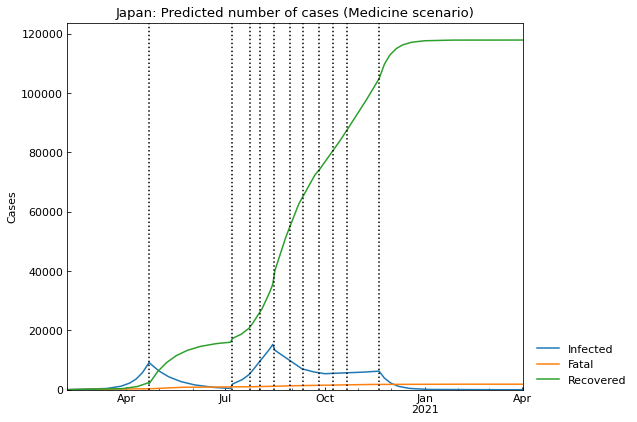

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,119703,1856,0,117847
418,2021-03-30,119703,1856,0,117847
419,2021-03-31,119703,1856,0,117847
420,2021-04-01,119703,1856,0,117847
421,2021-04-02,119703,1856,0,117847


In [40]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios

In [41]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,11th_Rt
Main,15246,14Aug2020,227312,10634,2663,1.04
Medicine,15246,14Aug2020,119703,0,1856,0.52


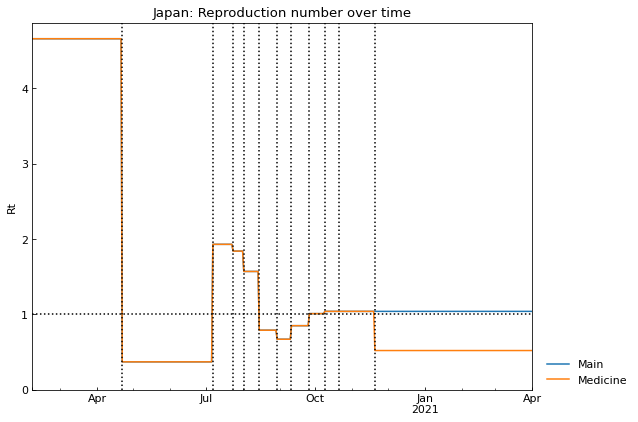

In [42]:
_ = snl.history(target="Rt")

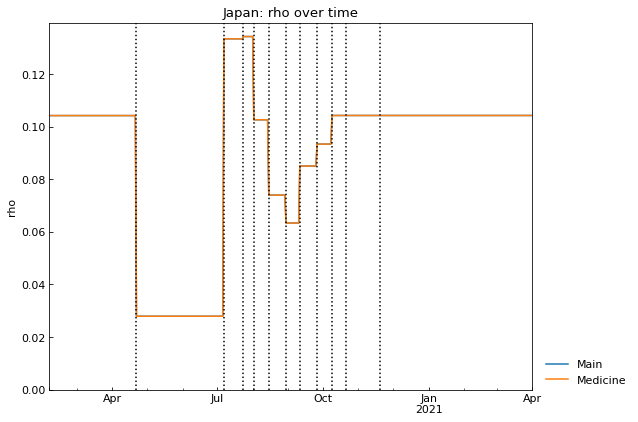

In [43]:
_ = snl.history(target="rho")

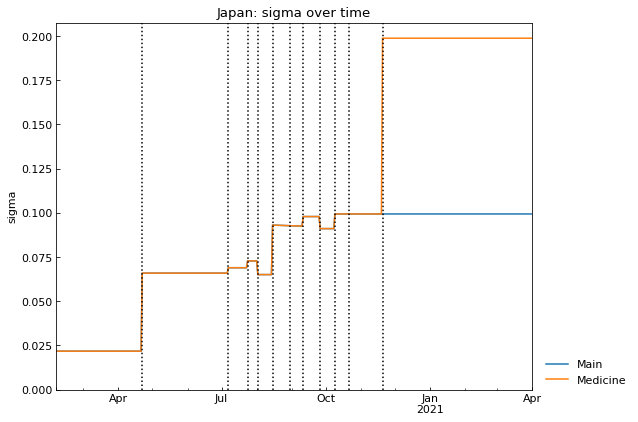

In [44]:
_ = snl.history(target="sigma")

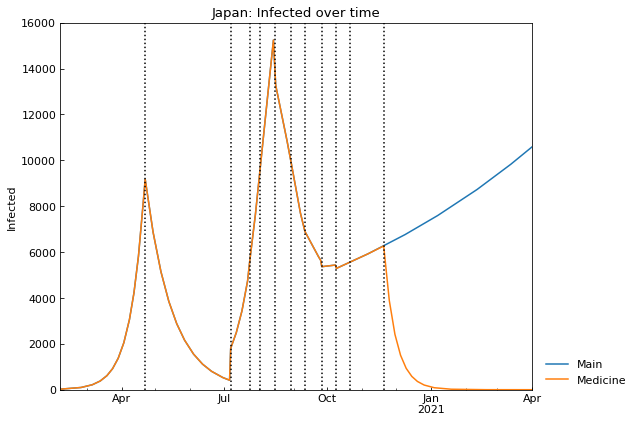

In [45]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario

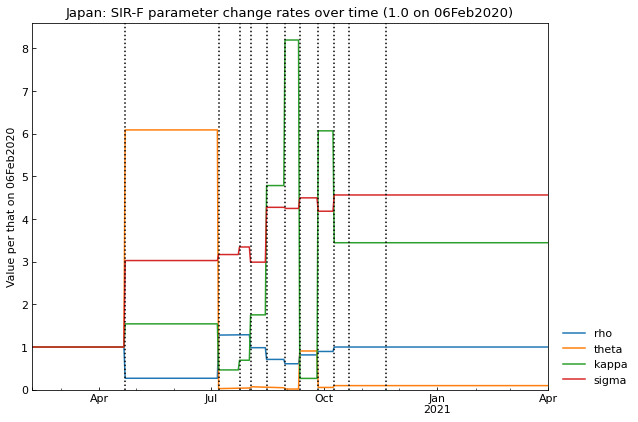

In [46]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [47]:
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	10th phase (09Oct2020 - 20Oct2020): finished  694 trials in 0 min 25 sec


	 2nd phase (07Jul2020 - 23Jul2020): finished  150 trials in 0 min  5 sec

	 3rd phase (24Jul2020 - 01Aug2020): finished 1038 trials in 0 min 45 sec

	 0th phase (06Feb2020 - 21Apr2020): finished 1313 trials in 1 min  0 sec

	 1st phase (22Apr2020 - 06Jul2020): finished 1332 trials in 1 min  0 sec

	 5th phase (15Aug2020 - 29Aug2020): finished  472 trials in 0 min 15 sec

	 4th phase (02Aug2020 - 14Aug2020): finished 1314 trials in 1 min  0 sec

	 6th phase (30Aug2020 - 31Aug2020): finished  227 trials in 0 min  5 sec

	 7th phase (01Sep2020 - 10Sep2020): finished  176 trials in 0 min  5 sec

	 8th phase (11Sep2020 - 25Sep2020): finished  437 trials in 0 min 10 sec

	 9th phase (26Sep2020 - 08Oct2020): finished 1856 trials in 1 min  0 sec

Completed optimization. Total: 2 min 31 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 7th phase (01Sep2020 - 20Oct2020): finished 5742 trials in 1 min  0 sec

Completed optimization. Total: 1 min  0 sec


In [48]:
snl_retro.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario      Phase                                                        
Main          0th    Past  06Feb2020  21Apr2020   126529100  SIR-F  4.66   
              1st    Past  22Apr2020  06Jul2020   126529100  SIR-F  0.37   
              2nd    Past  07Jul2020  23Jul2020   126529100  SIR-F  1.93   
              3rd    Past  24Jul2020  01Aug2020   126529100  SIR-F  1.84   
              4th    Past  02Aug2020  14Aug2020   126529100  SIR-F  1.54   
              5th    Past  15Aug2020  29Aug2020   126529100  SIR-F  0.79   
              6th    Past  30Aug2020  31Aug2020   126529100  SIR-F  0.92   
              7th    Past  01Sep2020  10Sep2020   126529100  SIR-F  0.69   
              8th    Past  11Sep2020  25Sep2020   126529100  SIR-F  0.85   
              9th    Past  26Sep2020  08Oct2020   126529100  SIR-F  1.01   
              10th   Past  09Oct2020  20Oct2020   126529100  SIR-F  1.04   
Retrospective 0th    Past  06Feb2020  21Apr2020   126529100  SIR-F  4.66   
              1st    Past  22Apr2020  06Jul2020   126529100  SIR-F  0.37   
              2nd    Past  07Jul2020  23Jul2020   126529100  SIR-F  1.93   
              3rd    Past  24Jul2020  01Aug2020   126529100  SIR-F  1.84   
              4th    Past  02Aug2020  14Aug2020   126529100  SIR-F  1.54   
              5th    Past  15Aug2020  29Aug2020   126529100  SIR-F  0.79   
              6th    Past  30Aug2020  31Aug2020   126529100  SIR-F  0.92   
              7th    Past  01Sep2020  20Oct2020   126529100  SIR-F  0.92   

                        theta     kappa       rho     sigma   tau  \
Scenario      Phase                                                 
Main          0th    0.018341  0.000174  0.104200  0.021769  1440   
              1st    0.111664  0.000268  0.027925  0.065885  1440   
              2nd    0.000466  0.000080  0.133382  0.068954  1440   
              3rd    0.000726  0.000120  0.134241  0.072807  1440   
              4th    0.000361  0.000256  0.102521  0.066353  1440   
              5th    0.000844  0.000831  0.073977  0.093038  1440   
              6th    0.023294  0.000043  0.061460  0.065209  1440   
              7th    0.000682  0.001661  0.066885  0.095150  1440   
              8th    0.016642  0.000046  0.085008  0.097873  1440   
              9th    0.000972  0.001053  0.093356  0.091061  1440   
              10th   0.001755  0.000598  0.104236  0.099343  1440   
Retrospective 0th    0.018341  0.000174  0.104200  0.021769  1440   
              1st    0.111664  0.000268  0.027925  0.065885  1440   
              2nd    0.000466  0.000080  0.133382  0.068954  1440   
              3rd    0.000726  0.000120  0.134241  0.072807  1440   
              4th    0.000361  0.000256  0.102521  0.066353  1440   
              5th    0.000844  0.000831  0.073977  0.093038  1440   
              6th    0.023294  0.000043  0.061460  0.065209  1440   
              7th    0.023294  0.000043  0.061460  0.065209  1440   

                     1/alpha2 [day]  alpha1 [-]  1/gamma [day]  1/beta [day]  \
Scenario      Phase                                                            
Main          0th              5760       0.018             45             9   
              1st              3732       0.112             15            35   
              2nd             12426       0.000             14             7   
              3rd              8341       0.001             13             7   
              4th              3904       0.000             15             9   
              5th              1204       0.001             10            13   
              6th             23018       0.023             15            16   
              7th               602       0.001             10            14   
              8th             21764       0.017             10            11   
              9th               949       0.001             10            10   
              

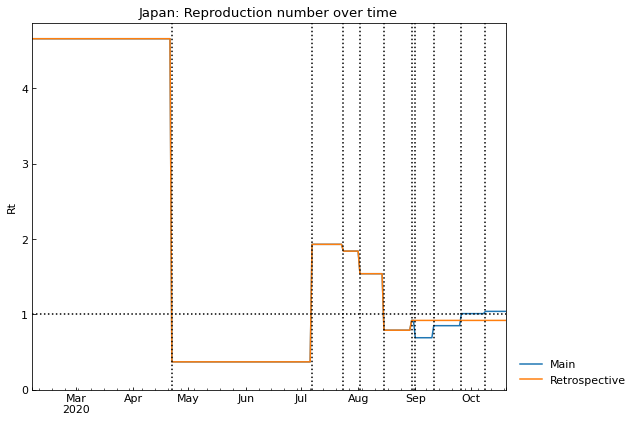

Scenario,Main,Retrospective
Date,,
2020-02-06,4.66,4.66
2020-02-07,4.66,4.66
2020-02-08,4.66,4.66
2020-02-09,4.66,4.66
2020-02-10,4.66,4.66
...,...,...
2020-10-16,1.04,0.92
2020-10-17,1.04,0.92
2020-10-18,1.04,0.92


In [49]:
snl_retro.history("Rt")

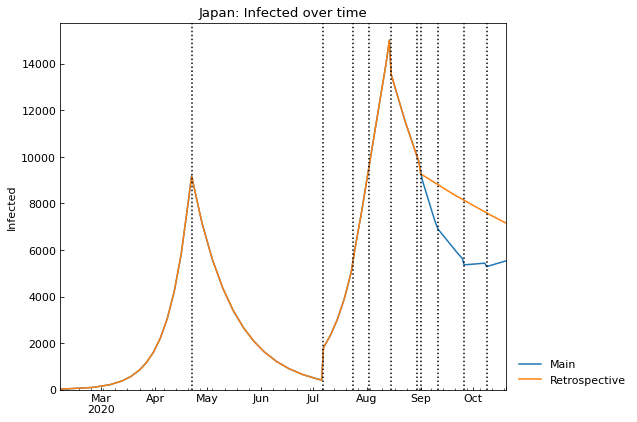

Scenario,Main,Retrospective
Date,,
2020-02-06,21,21
2020-02-07,23,23
2020-02-08,25,25
2020-02-09,27,27
2020-02-10,29,29
...,...,...
2020-10-16,5442,7318
2020-10-17,5464,7279
2020-10-18,5486,7241


In [50]:
snl_retro.history("Infected")

In [51]:
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 21Oct2020,Infected on 21Oct2020,Fatal on 21Oct2020,7th_Rt,8th_Rt,9th_Rt,10th_Rt
Main,15023,14Aug2020,94415,5553,1667,0.69,0.85,1.01,1.04
Retrospective,15023,14Aug2020,93433,7128,1897,0.92,-,-,-
